In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# this file implements:
# fixed spread for symmetric strategy: Inventory strategy unchanged, but the spread of the symmetric strategy is fixed,which only depends on gamma and k.

In [2]:
class AvellanedaStoikov:
    def __init__(self, sigma=2.0, gamma=0.1, k=1.5, A=140, T=1.0, dt=0.005):
        self.sigma = sigma   # fixed
        self.gamma = gamma
        self.k = k
        self.A = A     
        self.T = T           # time
        self.dt = dt   
    
    def optimal_quotes(self, s, t, i):
        reservation_price=s-i*self.gamma*(self.sigma**2)*(self.T-t)
        spread=self.gamma*(self.sigma**2)*(self.T-t)+2.0/self.gamma*np.log(1+self.gamma/self.k)
        
        delta_common_part=1.0/self.gamma*np.log(1+self.gamma/self.k)
        delta_ask=(1-2*i)*self.gamma*(self.sigma**2)*(self.T-t)/2.0+delta_common_part
        delta_bid=(2*i+1)*self.gamma*(self.sigma**2)*(self.T-t)/2.0+delta_common_part
        
        return (reservation_price,spread,delta_ask,delta_bid)
    
    def browanian_motion(self, initial_s):
        white_noise=self.sigma*np.sqrt(self.dt)*np.random.choice([1,-1],int(self.T/self.dt))
        brownian_motion=initial_s+np.cumsum(white_noise)
        brownian_motion=np.insert(brownian_motion,0,initial_s)
        return brownian_motion
    
    def simulate(self, initial_s=100.0, initial_i=0):
        steps = int(self.T / self.dt)
        times = np.linspace(0, self.T, steps+1)
        mid_prices = self.browanian_motion(initial_s)  # len: steps+1
        
        # Initialize arrays
        reservation_prices=np.zeros(steps+1)
        spreads = np.zeros(steps+1)
        ask_prices = np.zeros(steps+1)
        bid_prices = np.zeros(steps+1)
        inventory = np.zeros(steps+1, dtype=int)  # orders are transaction after setting prices
        cash=np.zeros(steps+1)                    # so is cash decided
        pnl=np.zeros(steps+1)                     # so is profit & loss decided
        
        symmetric_ask_prices=np.zeros(steps+1)
        symmetric_bid_prices=np.zeros(steps+1)
        symmetric_inventory=np.zeros(steps+1, dtype=int)
        symmetric_cash=np.zeros(steps+1)
        symmetric_pnl=np.zeros(steps+1)
        
        # fixed symmetric spread
        symmetric_spread=2.0/self.gamma*np.log(1+self.gamma/self.k)  
        
        # Simulate
        for i,s in enumerate(mid_prices):
            if i==0:
                # Set initial values
                inventory[0] = initial_i
                cash[0]=0
                pnl[0]=0
                symmetric_inventory[0] = initial_i
                symmetric_cash[0]=0
                symmetric_pnl[0]=0
            else:
                # update inventory and pnl
                # inventory strategy
                prob_ask = self.A*np.exp(-self.k*delta_ask)*self.dt  # delta is relative to mid-price, so here is delta_ask/bid
                prob_bid = self.A*np.exp(-self.k*delta_bid)*self.dt
                prob_ask=max(0,min(prob_ask,1))
                prob_bid=max(0,min(prob_bid,1))
                dNa = np.random.choice([1, 0],p=[prob_ask, 1 - prob_ask])
                dNb = np.random.choice([1, 0],p=[prob_bid, 1 - prob_bid])
                inventory[i]=inventory[i-1]-dNa+dNb
                cash[i]=cash[i-1]+ask*dNa-bid*dNb
                pnl[i]=cash[i]+inventory[i]*s
                
                # symmetric strategy
                prob_ask = self.A*np.exp(-self.k*symmetric_spread/2.0)*self.dt  # delta is relative to mid-price, so here is spread/2
                prob_bid = self.A*np.exp(-self.k*symmetric_spread/2.0)*self.dt
                prob_ask=max(0,min(prob_ask,1))
                prob_bid=max(0,min(prob_bid,1))
                dNa = np.random.choice([1, 0],p=[prob_ask, 1 - prob_ask])
                dNb = np.random.choice([1, 0],p=[prob_bid, 1 - prob_bid])
                symmetric_inventory[i]=symmetric_inventory[i-1]-dNa+dNb
                symmetric_cash[i]=symmetric_cash[i-1]+symmetric_ask*dNa-symmetric_bid*dNb
                symmetric_pnl[i]=symmetric_cash[i]+symmetric_inventory[i]*s
                
            # Get optimal quotes
            reservation_price,spread, delta_ask, delta_bid = self.optimal_quotes(s, times[i], inventory[i])
            ask=reservation_price+spread/2.0
            bid=reservation_price-spread/2.0
            symmetric_ask=s+symmetric_spread/2.0
            symmetric_bid=s-symmetric_spread/2.0
            
            # update prices
            reservation_prices[i]=reservation_price
            spreads[i] = spread
            ask_prices[i] = ask
            bid_prices[i] = bid
            symmetric_ask_prices[i] = symmetric_ask
            symmetric_bid_prices[i] = symmetric_bid
        
        # Create DataFrame with results
        results = pd.DataFrame({
            'time': times,
            'mid_price': mid_prices,
            'reservation_price':reservation_prices,
            'spread': spreads,
            'ask_price': ask_prices,
            'bid_price': bid_prices,
            'inventory': inventory,
            'cash':cash,
            'pnl':pnl,
            'symmetric_ask_price': symmetric_ask_prices,
            'symmetric_bid_price': symmetric_bid_prices,
            'symmetric_inventory': symmetric_inventory,
            'symmetric_cash':symmetric_cash,
            'symmetric_pnl':symmetric_pnl,
        })
        return results

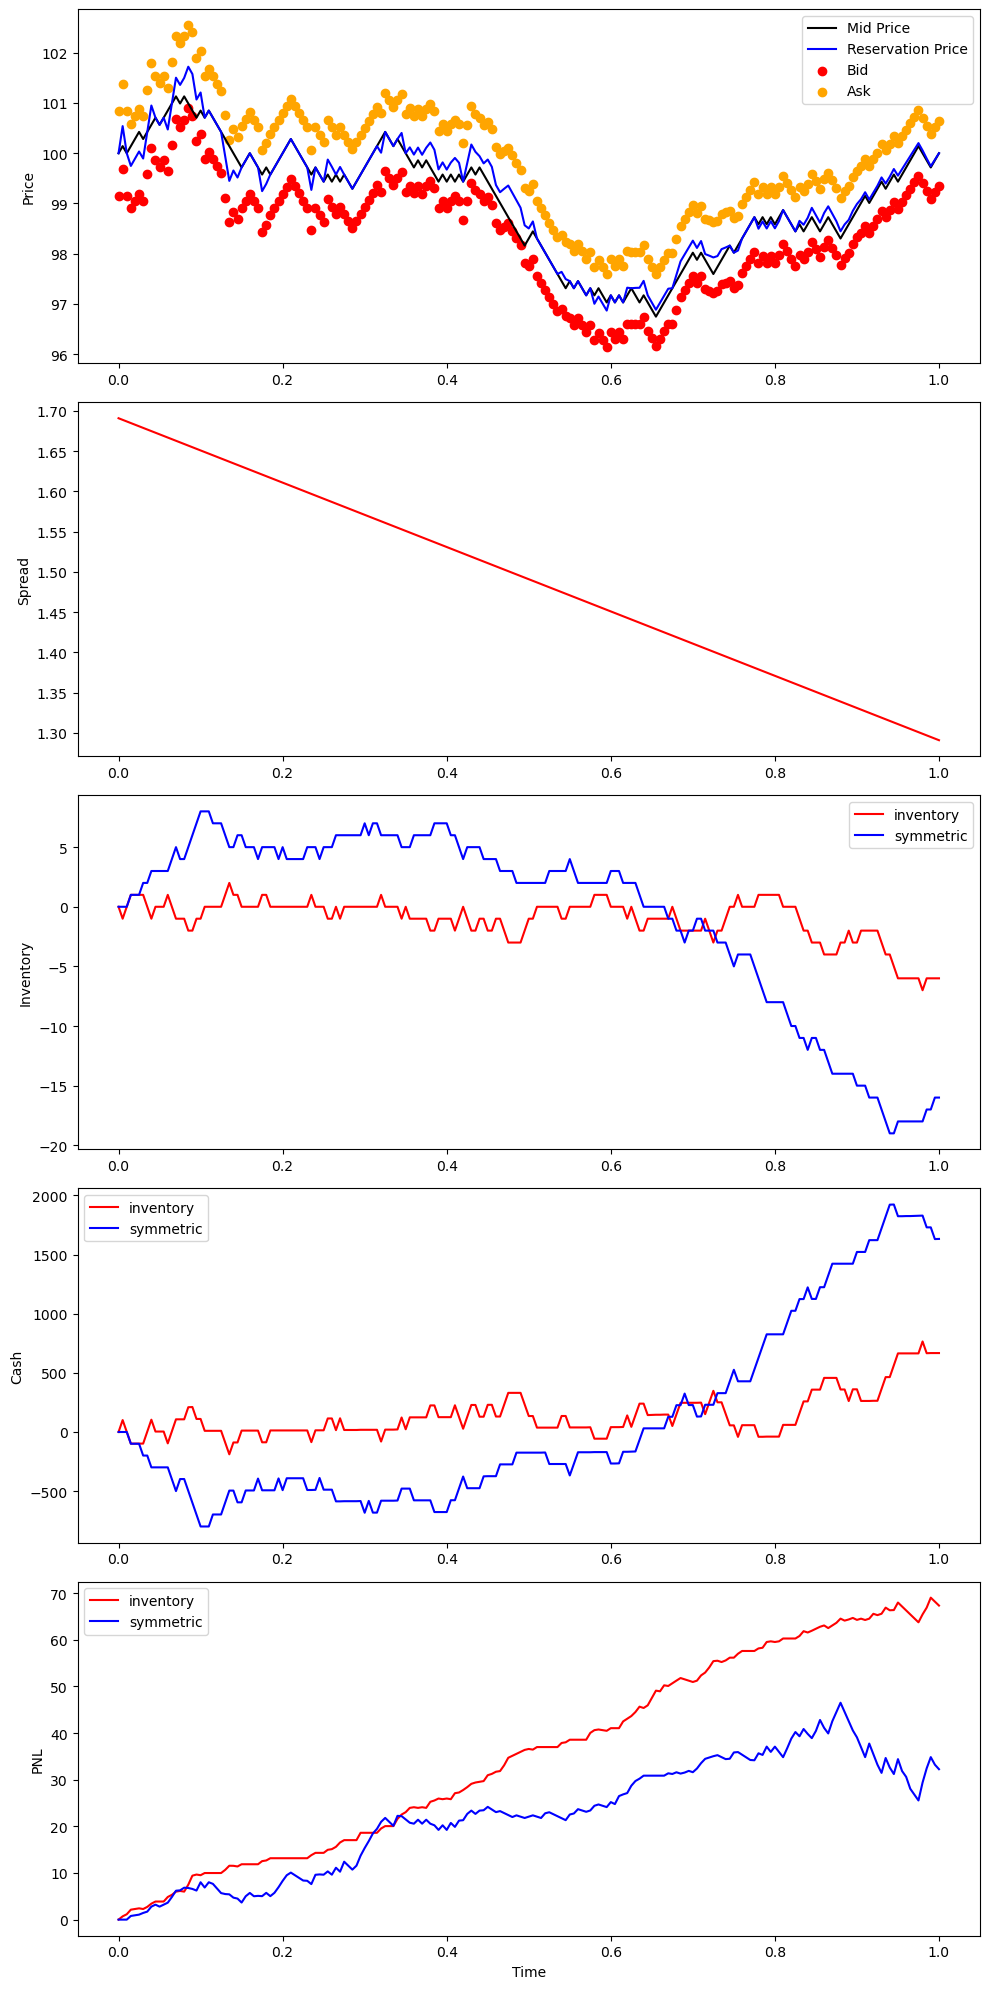

In [3]:
mm = AvellanedaStoikov()
results = mm.simulate(initial_s=100.0, initial_i=0)

plt.figure(figsize=(10, 20))
plt.subplot(5, 1, 1)
plt.plot(results['time'], results['mid_price'], color='black', label='Mid Price')
plt.plot(results['time'], results['reservation_price'], color='blue', label='Reservation Price')
plt.scatter(results['time'], results['bid_price'], color='red',label='Bid')
plt.scatter(results['time'], results['ask_price'], color='orange', label='Ask')
plt.ylabel('Price')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(results['time'], results['spread'],color='red')
plt.ylabel('Spread')

plt.subplot(5, 1, 3)
plt.plot(results['time'], results['inventory'],color='red',label='inventory')
plt.plot(results['time'], results['symmetric_inventory'],color='blue',label='symmetric')
plt.ylabel('Inventory')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(results['time'], results['cash'],color='red',label='inventory')
plt.plot(results['time'], results['symmetric_cash'],color='blue',label='symmetric')
plt.ylabel('Cash')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(results['time'], results['pnl'],color='red',label='inventory')
plt.plot(results['time'], results['symmetric_pnl'],color='blue',label='symmetric')
plt.ylabel('PNL')
plt.xlabel('Time')
plt.legend()

plt.tight_layout()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:17<00:00, 56.65it/s]


,pnl_mean,pnl_std,cash_mean,cash_std,inventory_mean,inventory_std
inventory,64.78,6.68,67.77,299.27,-0.03,3.00
symmetic,68.15,13.26,101.57,870.48,-0.33,8.71


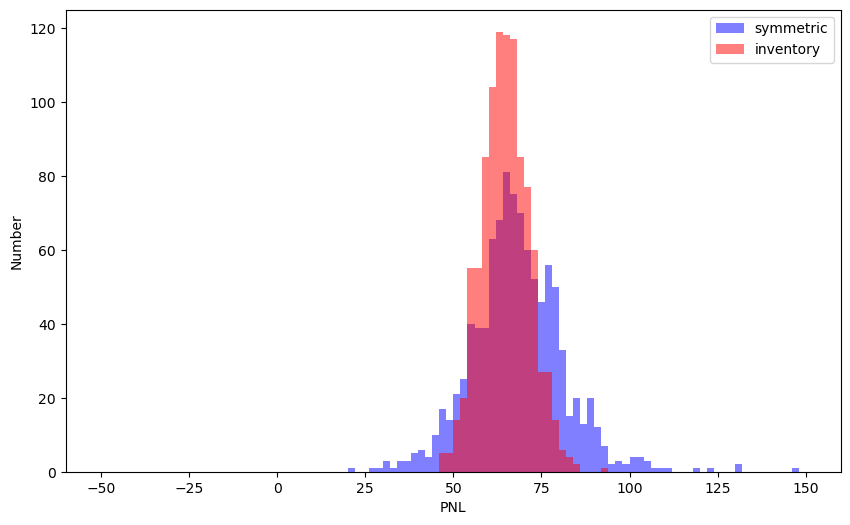

In [4]:
pnl_list=[]
cash_list=[]
inventory_list=[]
symmetric_pnl_list=[]
symmetric_cash_list=[]
symmetric_inventory_list=[]
for i in tqdm(range(1000)):
    results = mm.simulate(initial_s=100.0, initial_i=0)
    pnl_list.append(results['pnl'].iloc[-1])
    cash_list.append(results['cash'].iloc[-1])
    inventory_list.append(results['inventory'].iloc[-1])
    symmetric_pnl_list.append(results['symmetric_pnl'].iloc[-1])
    symmetric_cash_list.append(results['symmetric_cash'].iloc[-1])
    symmetric_inventory_list.append(results['symmetric_inventory'].iloc[-1])

data=pd.DataFrame(np.nan,index=['inventory','symmetic'],columns=['pnl_mean','pnl_std','cash_mean','cash_std','inventory_mean','inventory_std'])
data.loc['inventory','pnl_mean']=np.mean(pnl_list)
data.loc['inventory','pnl_std']=np.std(pnl_list)
data.loc['inventory','cash_mean']=np.mean(cash_list)
data.loc['inventory','cash_std']=np.std(cash_list)
data.loc['inventory','inventory_mean']=np.mean(inventory_list)
data.loc['inventory','inventory_std']=np.std(inventory_list)
data.loc['symmetic','pnl_mean']=np.mean(symmetric_pnl_list)
data.loc['symmetic','pnl_std']=np.std(symmetric_pnl_list)
data.loc['symmetic','cash_mean']=np.mean(symmetric_cash_list)
data.loc['symmetic','cash_std']=np.std(symmetric_cash_list)
data.loc['symmetic','inventory_mean']=np.mean(symmetric_inventory_list)
data.loc['symmetic','inventory_std']=np.std(symmetric_inventory_list)

plt.figure(figsize=(10, 6))
plt.hist(symmetric_pnl_list, range=(-50,150),bins=100, label='symmetric', color='blue',alpha=0.5)
plt.hist(pnl_list, range=(-50,150),bins=100, label='inventory', color='red',alpha=0.5)
plt.xlabel('PNL')
plt.ylabel('Number')
plt.legend()

data.round(2)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:16<00:00, 61.85it/s]


,pnl_mean,pnl_std,cash_mean,cash_std,inventory_mean,inventory_std
inventory,68.19,9.16,72.47,532.41,-0.05,5.32
symmetic,69.10,14.33,33.31,879.64,0.36,8.79


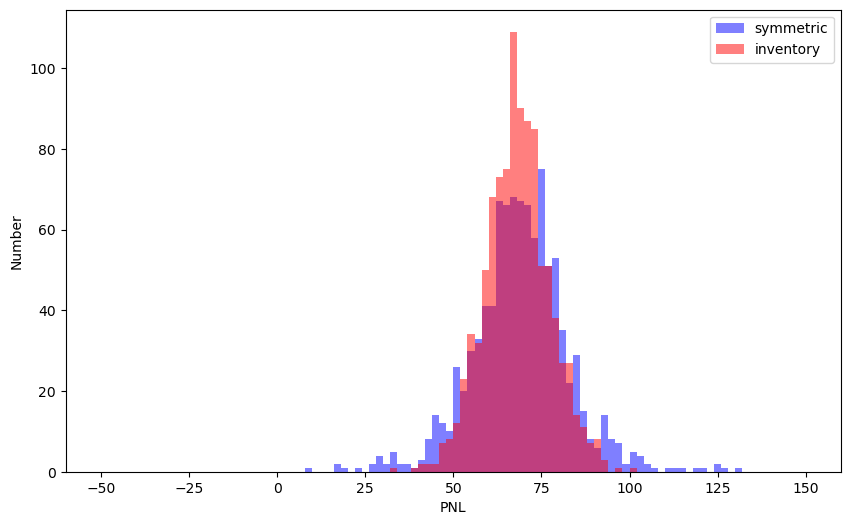

In [5]:
mm = AvellanedaStoikov(gamma=0.01)

pnl_list=[]
cash_list=[]
inventory_list=[]
symmetric_pnl_list=[]
symmetric_cash_list=[]
symmetric_inventory_list=[]
for i in tqdm(range(1000)):
    results = mm.simulate(initial_s=100.0, initial_i=0)
    pnl_list.append(results['pnl'].iloc[-1])
    cash_list.append(results['cash'].iloc[-1])
    inventory_list.append(results['inventory'].iloc[-1])
    symmetric_pnl_list.append(results['symmetric_pnl'].iloc[-1])
    symmetric_cash_list.append(results['symmetric_cash'].iloc[-1])
    symmetric_inventory_list.append(results['symmetric_inventory'].iloc[-1])

data=pd.DataFrame(np.nan,index=['inventory','symmetic'],columns=['pnl_mean','pnl_std','cash_mean','cash_std','inventory_mean','inventory_std'])
data.loc['inventory','pnl_mean']=np.mean(pnl_list)
data.loc['inventory','pnl_std']=np.std(pnl_list)
data.loc['inventory','cash_mean']=np.mean(cash_list)
data.loc['inventory','cash_std']=np.std(cash_list)
data.loc['inventory','inventory_mean']=np.mean(inventory_list)
data.loc['inventory','inventory_std']=np.std(inventory_list)
data.loc['symmetic','pnl_mean']=np.mean(symmetric_pnl_list)
data.loc['symmetic','pnl_std']=np.std(symmetric_pnl_list)
data.loc['symmetic','cash_mean']=np.mean(symmetric_cash_list)
data.loc['symmetic','cash_std']=np.std(symmetric_cash_list)
data.loc['symmetic','inventory_mean']=np.mean(symmetric_inventory_list)
data.loc['symmetic','inventory_std']=np.std(symmetric_inventory_list)

plt.figure(figsize=(10, 6))
plt.hist(symmetric_pnl_list, range=(-50,150),bins=100, label='symmetric', color='blue',alpha=0.5)
plt.hist(pnl_list, range=(-50,150),bins=100, label='inventory', color='red',alpha=0.5)
plt.xlabel('PNL')
plt.ylabel('Number')
plt.legend()

data.round(2)

100%|██████████| 1000/1000 [00:16<00:00, 59.72it/s]


,pnl_mean,pnl_std,cash_mean,cash_std,inventory_mean,inventory_std
inventory,48.45,5.82,44.59,193.86,0.04,1.93
symmetic,67.75,14.46,112.98,911.69,-0.44,9.11


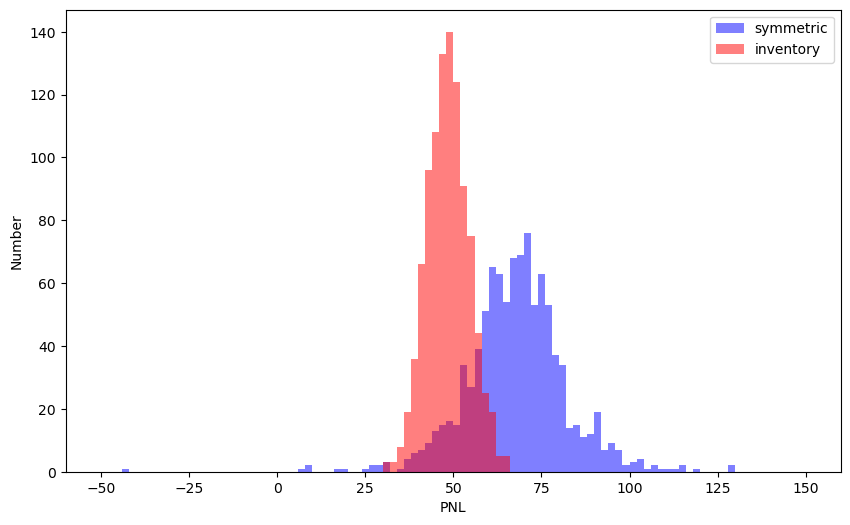

In [6]:
mm = AvellanedaStoikov(gamma=0.5)

pnl_list=[]
cash_list=[]
inventory_list=[]
symmetric_pnl_list=[]
symmetric_cash_list=[]
symmetric_inventory_list=[]
for i in tqdm(range(1000)):
    results = mm.simulate(initial_s=100.0, initial_i=0)
    pnl_list.append(results['pnl'].iloc[-1])
    cash_list.append(results['cash'].iloc[-1])
    inventory_list.append(results['inventory'].iloc[-1])
    symmetric_pnl_list.append(results['symmetric_pnl'].iloc[-1])
    symmetric_cash_list.append(results['symmetric_cash'].iloc[-1])
    symmetric_inventory_list.append(results['symmetric_inventory'].iloc[-1])

data=pd.DataFrame(np.nan,index=['inventory','symmetic'],columns=['pnl_mean','pnl_std','cash_mean','cash_std','inventory_mean','inventory_std'])
data.loc['inventory','pnl_mean']=np.mean(pnl_list)
data.loc['inventory','pnl_std']=np.std(pnl_list)
data.loc['inventory','cash_mean']=np.mean(cash_list)
data.loc['inventory','cash_std']=np.std(cash_list)
data.loc['inventory','inventory_mean']=np.mean(inventory_list)
data.loc['inventory','inventory_std']=np.std(inventory_list)
data.loc['symmetic','pnl_mean']=np.mean(symmetric_pnl_list)
data.loc['symmetic','pnl_std']=np.std(symmetric_pnl_list)
data.loc['symmetic','cash_mean']=np.mean(symmetric_cash_list)
data.loc['symmetic','cash_std']=np.std(symmetric_cash_list)
data.loc['symmetic','inventory_mean']=np.mean(symmetric_inventory_list)
data.loc['symmetic','inventory_std']=np.std(symmetric_inventory_list)

plt.figure(figsize=(10, 6))
plt.hist(symmetric_pnl_list, range=(-50,150),bins=100, label='symmetric', color='blue',alpha=0.5)
plt.hist(pnl_list, range=(-50,150),bins=100, label='inventory', color='red',alpha=0.5)
plt.xlabel('PNL')
plt.ylabel('Number')
plt.legend()

data.round(2)